In [1]:
import pandas as pd
import numpy as np
import zipfile

## Import Data

In [2]:
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Parcel.zip
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip

In [3]:
# with zipfile.ZipFile('../../data/raw/Parcel.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')
# with zipfile.ZipFile('../../data/raw/Real Property Sales.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')
# with zipfile.ZipFile('../../data/raw/Residential Building.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')

In [166]:
parcel = pd.read_csv("../../data/raw/EXTR_Parcel.csv", encoding='latin-1')
real_property_sales = pd.read_csv("../../data/raw/EXTR_RPSale.csv", encoding='latin-1', low_memory=False)
residential_building = pd.read_csv("../../data/raw/EXTR_ResBldg.csv", encoding='latin-1', low_memory=False)

## Clean Data and Filter For Needed Info

### Property Sales

In [167]:
# Real Property Sales
# Identifyers are Major and Minor. Relevant data is SalePrice
# Clean real_property_sales to have proper values in Minor and Major and change type to int to match other data sets
real_property_sales = real_property_sales[['Major', 'Minor', 'SalePrice', 'DocumentDate']]
real_property_sales = real_property_sales[(real_property_sales['Major'].str.isdecimal()==True) &
                                          (real_property_sales['Minor'].str.isdecimal()==True)]
real_property_sales['Major'] = real_property_sales['Major'].astype('int64')
real_property_sales['Minor'] = real_property_sales['Minor'].astype('int64')
real_property_sales = real_property_sales[real_property_sales['SalePrice']>0]

In [168]:
real_property_sales.head()

,Major,Minor,SalePrice,DocumentDate
2,330395,1610,335000,06/07/2012
3,675260,940,209950,03/06/1998
5,269549,190,154950,07/23/2000
6,638580,110,190000,07/14/2015
8,321165,50,2100000,05/10/2004


### Parcel

In [169]:
# Parcel Filter for Necessary Columns
parcel = parcel[['Major', 'Minor', 'PropType', 'SqFtLot', 'WfntLocation',
                 'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances']]
parcel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616110 entries, 0 to 616109
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Major           616110 non-null  int64 
 1   Minor           616110 non-null  int64 
 2   PropType        616110 non-null  object
 3   SqFtLot         616110 non-null  int64 
 4   WfntLocation    616110 non-null  int64 
 5   TrafficNoise    616110 non-null  int64 
 6   AirportNoise    616110 non-null  int64 
 7   PowerLines      616110 non-null  object
 8   OtherNuisances  616110 non-null  object
dtypes: int64(6), object(3)
memory usage: 42.3+ MB


In [170]:
parcel = parcel[(parcel['PropType']=='R') | (parcel['PropType']=='K')]

### Residential Buiding

In [171]:
# residential_building.info()

In [172]:
# Residential Buiding Filter For Necessary Columns
residential_building = residential_building[['Major', 'Minor', 'ZipCode', 'NbrLivingUnits', 'SqFtTotLiving', 'SqFtOpenPorch', 'SqFtEnclosedPorch']]

In [173]:
# Create a column Has_Porch
residential_building['Has_Porch']= residential_building['SqFtOpenPorch'] + residential_building['SqFtEnclosedPorch']
residential_building['Has_Porch'] = [1  if p>0 else 0 for p in residential_building['Has_Porch']]

In [174]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517783 entries, 0 to 517782
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Major              517783 non-null  int64 
 1   Minor              517783 non-null  int64 
 2   ZipCode            470012 non-null  object
 3   NbrLivingUnits     517783 non-null  int64 
 4   SqFtTotLiving      517783 non-null  int64 
 5   SqFtOpenPorch      517783 non-null  int64 
 6   SqFtEnclosedPorch  517783 non-null  int64 
 7   Has_Porch          517783 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 31.6+ MB


### Merge Property Sales, parcel, and residential building data

In [175]:
# Join all the tables on Major, Minor
# Have duplicate buildings sold at different dates. Need to only keep latest dates
merged_tables = (parcel.merge(real_property_sales, on = ['Major', 'Minor'])).merge(residential_building, on = ['Major', 'Minor']).drop_duplicates()
# Change dates to date time format
merged_tables[['Major', 'SqFtLot']].head(20)
merged_tables['DocumentDate'] = pd.to_datetime(merged_tables['DocumentDate'])

In [176]:
merged_tables.shape

(991782, 17)

In [177]:
#Keeping only the most recent Sale_Price

merged_tables = merged_tables.sort_values(by=['Major', 'DocumentDate'])
merged_tables.drop_duplicates(subset=['Major', 'Minor'], keep='last', inplace=True)

In [178]:
# Filtering for only 2019 data
start_date = "2019-1-1"
end_date = "2019-12-31"
merged_tables = merged_tables.loc[(merged_tables["DocumentDate"] >= start_date) & (merged_tables["DocumentDate"] <= end_date)]

merged_tables.shape

(28009, 17)

In [179]:
# change dataframe name to df to make life easier
df = merged_tables #.sort_values(by = 'DocumentDate', ascending=False)

#Create Nuisances Column to replace other nuisance columns
df['Nuisances'] = 'No Nuisances'
df.loc[(df['TrafficNoise']>0), 'Nuisances'] = 'Traffic Noise'
df.loc[(df['AirportNoise']>0), 'Nuisances'] = 'Airport Noise'
df.loc[(df['PowerLines']=='Y'), 'Nuisances'] = 'Power Lines'
df.loc[(df['OtherNuisances']=='Y'), 'Nuisances'] = 'Other Nuisances'
df = df.drop(['SqFtOpenPorch', 'SqFtEnclosedPorch'], axis='columns')
df['PowerLines'] = df['PowerLines'].map({'Y' : 1, 'N' : 0})
df['OtherNuisances'] = df['OtherNuisances'].map({'Y' : 1, 'N' : 0})

In [180]:
# WFNTLOCATION
# Waterfront location (Source: King County Assessments)
# Value	Definition
# 0	Unknown
# 1	Duwamish
# 2	Elliott Bay
# 3	Puget Sound
# 4	Lake Union
# 5	Ship Canal
# 6	Lake Washington
# 7	Lake Sammamish
# 8	Other lake
# 9	River or slough

df['WaterFrontLocation'] = df.WfntLocation.map({0 : 'None', 1 : 'Duwamish', 2 : 'Elliott Bay', 3 : 'Puget Sound', 4 : 'Lake Union',
                     5 : 'Ship Canal',  6 : 'Lake Washington', 7 : 'Lake Sammamish', 8 : 'Other lake', 9 : 'River or slough'})
df['Is_WaterFrontLocation'] = [1 if i>0 else 0 for i in df.WfntLocation]
df=df.drop('WfntLocation', axis='columns')

In [181]:
df['Has_Nuisance'] = [0 if n == 'No Nuisances' else 1 for n in df['Nuisances']]

# df[['Major', 'Minor', 'SqFtLot']].head()
# df.info()()

In [182]:
 df = df[['Major', 'Minor', 'ZipCode', 'DocumentDate', 'SalePrice',
          'SqFtLot', 'SqFtTotLiving', 'Nuisances', 'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Has_Nuisance',
          'WaterFrontLocation', 'Is_WaterFrontLocation', 'Has_Porch',
          'PropType', 'NbrLivingUnits']]
df = df.sort_values(by='Major')
df.head()

,Major,Minor,ZipCode,DocumentDate,SalePrice,SqFtLot,SqFtTotLiving,Nuisances,TrafficNoise,PowerLines,OtherNuisances,Has_Nuisance,WaterFrontLocation,Is_WaterFrontLocation,Has_Porch,PropType,NbrLivingUnits
258630,100,67,98002,2019-04-01,310800,17400,2240,No Nuisances,0,0,0,0,None,0,1,R,1
73397,100,66,98002,2019-10-22,339000,14500,1200,No Nuisances,0,0,0,0,None,0,1,R,1
537664,100,42,NaN,2019-10-29,485500,6002,2134,No Nuisances,0,0,0,0,None,0,1,R,1
89188,120,8,98166,2019-05-17,850000,24142,3500,No Nuisances,0,0,0,0,None,0,0,R,1
587592,140,27,98178,2019-05-28,535000,14208,2170,Traffic Noise,1,0,0,1,None,0,0,R,1


In [183]:
df.info()
# ZipCode 24492 non-null objects of 29996 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28009 entries, 258630 to 909818
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Major                  28009 non-null  int64         
 1   Minor                  28009 non-null  int64         
 2   ZipCode                22870 non-null  object        
 3   DocumentDate           28009 non-null  datetime64[ns]
 4   SalePrice              28009 non-null  int64         
 5   SqFtLot                28009 non-null  int64         
 6   SqFtTotLiving          28009 non-null  int64         
 7   Nuisances              28009 non-null  object        
 8   TrafficNoise           28009 non-null  int64         
 9   PowerLines             28009 non-null  int64         
 10  OtherNuisances         28009 non-null  int64         
 11  Has_Nuisance           28009 non-null  int64         
 12  WaterFrontLocation     28009 non-null  object        


In [184]:
# Check x if have the relevant data to answer question
# [x]Higher square footage increases home sale price1, 2
# [x]Having a porch increases home sale price3, 4
# [x]Having a beachfront or lakefront increases home sale price5
# [x]The house filling a higher proportion of the overall lot decreases home sale price6
# [x]The cost per square foot is lower in duplexes than in single-family homes7
# [x]The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price1, 5

## Graphical EDA

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

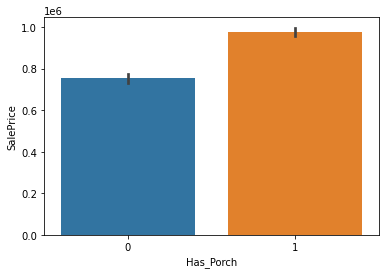

In [186]:
sns.barplot(df['Has_Porch'], df['SalePrice']);

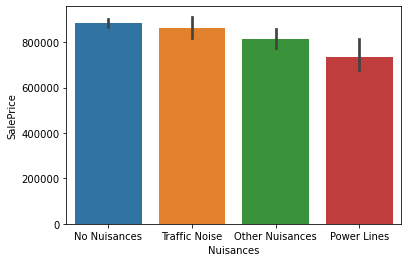

In [187]:
sns.barplot(df['Nuisances'], df['SalePrice']);

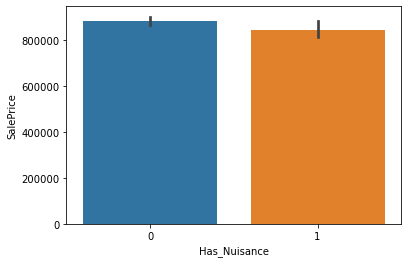

In [188]:
sns.barplot(df['Has_Nuisance'], df['SalePrice']);

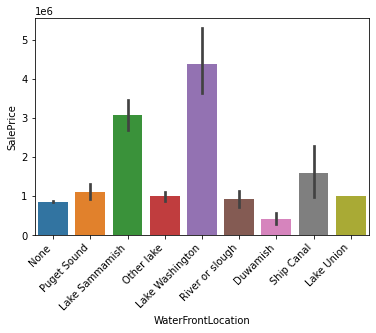

In [189]:
chart = sns.barplot(df.WaterFrontLocation, df.SalePrice)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

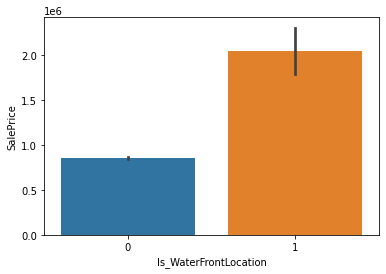

In [190]:
sns.barplot(df.Is_WaterFrontLocation, df.SalePrice);

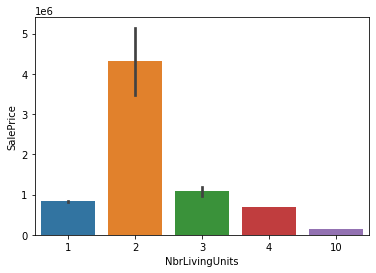

In [191]:
sns.barplot(df.NbrLivingUnits, df.SalePrice);

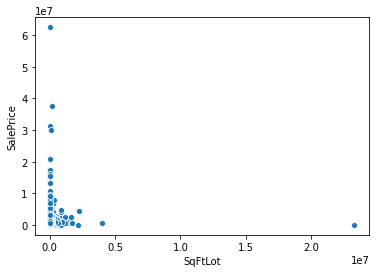

In [192]:
sns.scatterplot(df['SqFtLot'], df['SalePrice'])

### Plot some distributions and box plots and Remove Outliers

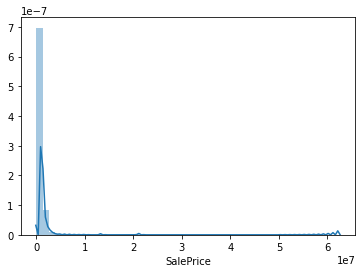

In [193]:
sns.distplot(df['SalePrice'])

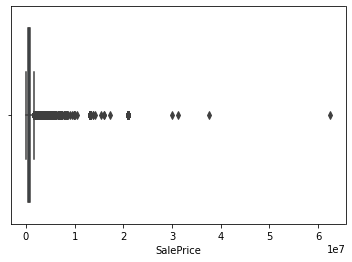

In [194]:
sns.boxplot(df['SalePrice'])

In [319]:
df2 = df[df['SalePrice'].between(df['SalePrice'].quantile(.004), df['SalePrice'].quantile(.996))]

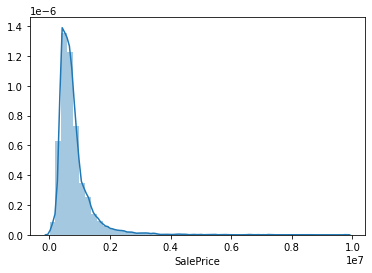

In [320]:
sns.distplot(df2['SalePrice'])

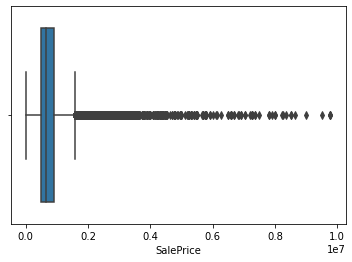

In [321]:
sns.boxplot(df2['SalePrice'])

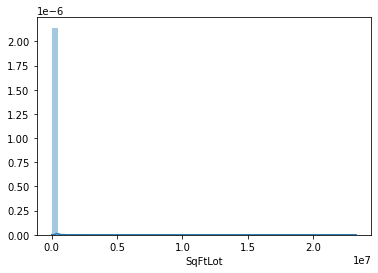

In [322]:
sns.distplot(df2['SqFtLot'])

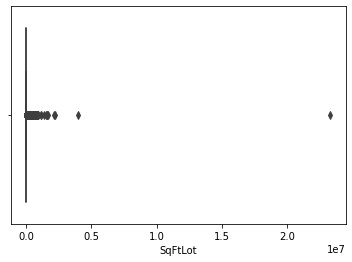

In [323]:
sns.boxplot(df['SqFtLot'])

In [324]:
df2 = df2[df2['SqFtLot'].between(df2['SqFtLot'].quantile(.001), df2['SqFtLot'].quantile(.999))]

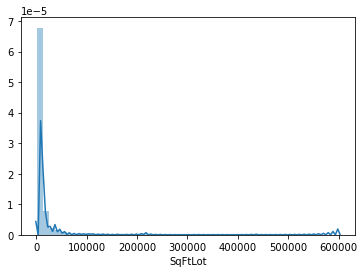

In [325]:
sns.distplot(df2['SqFtLot'])

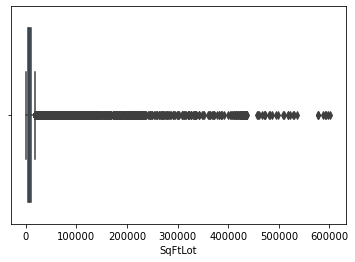

In [326]:
sns.boxplot(df2['SqFtLot'])

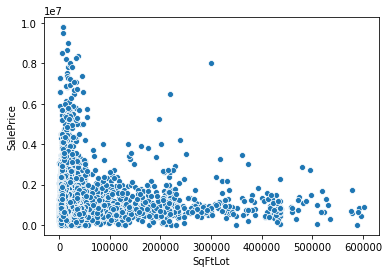

In [327]:
sns.scatterplot(df2['SqFtLot'], df2['SalePrice'])

In [328]:
df2=df2.reset_index(drop=True)

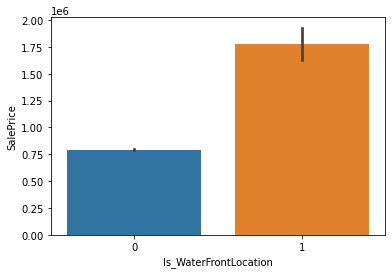

In [329]:
sns.barplot(df2.Is_WaterFrontLocation, df2.SalePrice);

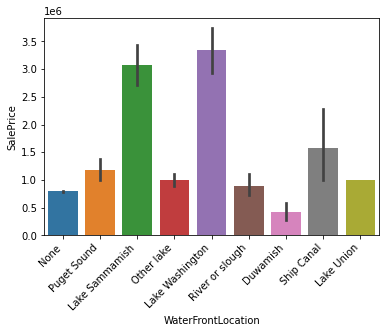

In [330]:
chart = sns.barplot(df2.WaterFrontLocation, df2.SalePrice)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

In [331]:
df2['SalePrice'].max()

9775000

In [332]:
len(df2)

27728

In [333]:
df2.to_csv('../../data/clean/KingCountyHousingData.csv')